In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special

from num_methods.integral import TrapzIntegral
from numpy import sqrt, sin, cos, pi

beg = 0
end = 15
main_rng = np.arange(beg, end, 0.1)

def mk_plot(func, rng, label, same=False):
    plt.plot(rng, [func(x) for x in rng], label=label)
    plt.grid(True)
    plt.legend()
    if not same:
        plt.show()

Будем использовать для тестов следующие функции

Обычная:

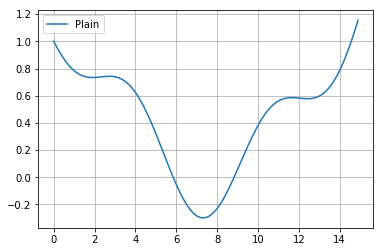

In [2]:
plain_func = lambda x: special.jv(2.5, x) + (x ** 2 - 14 * x + 49) / 49

mk_plot(plain_func, main_rng, 'Plain')

С разрывом:

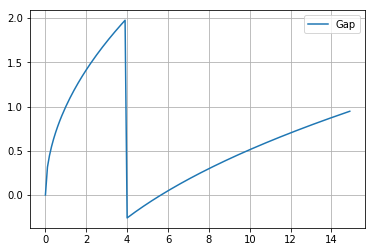

In [3]:
gap_func = lambda x: x ** 0.5 if x < 4. else x ** 0.4 - 2.

mk_plot(gap_func, main_rng, 'Gap')

Осцелирующая:

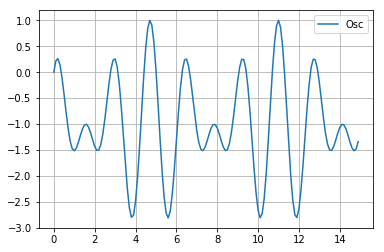

In [4]:
osc_func = lambda x: sin(x * 3) + cos(x * 4) - 1

mk_plot(osc_func, main_rng, 'Osc')

Реализуем два митода интегрирования: формулу Симпсона и метод трапеций (пока что лишь для равномерных сеток).

Простая формула для метода трапеций на отрезке $[a, b]$: $(b - a) \cdot \frac{f(a) + f(b)}{2}$

Составная формула
$$\frac{f(a)}{2} (x_1 - a) + \sum_{i=1}^{n-1} \frac{f(x_i)}{2} (x_{i+1} - x_{i-1}) + \frac{f(b)}{2} (b - x_{n-1})$$
для равномерной сетки шага $h$
$$I_{trap} \approx h\left( \frac{f(a) + f(b)}{2} + \sum_{i=1}^{n - 1} f(a + hi) \right)$$

Погрешность можно оценить как $|I_* - I_{trap}| \le ch^2$, где $I_*$ -- реальное значение интеграла.

Вычеслим интегралы на отрезке $[0, 15]$ с числом узлов 10000 и сравним с библиотечным методом.

In [9]:
funcs = [(gap_func, 'Gap'), (osc_func, 'Osc'), (plain_func, 'Plain')]

for func, name in funcs:
    res = integrate.quad(func, beg, end)[0]
    print(f'Framework method result is {res:.4f}')
    my_res = TrapzIntegral(func, nodes_num=10000)(end, begin=beg)
    print('Trapeze integral of', name, f'function is {my_res:.4f}')
    print()

Framework method result is 10.0107
Trapeze integral of Gap function is 10.0110

Framework method result is -14.9180
Trapeze integral of Osc function is -14.9180

Framework method result is 6.6371
Trapeze integral of Plain function is 6.6371



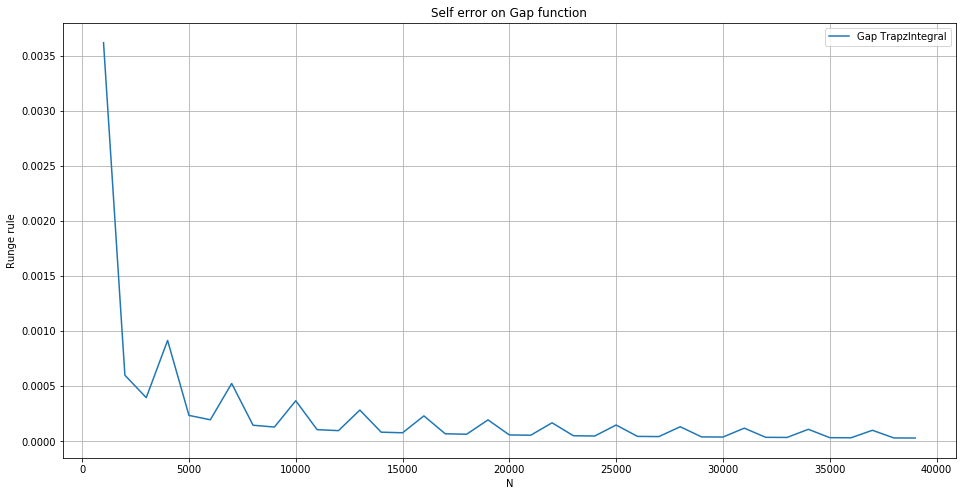

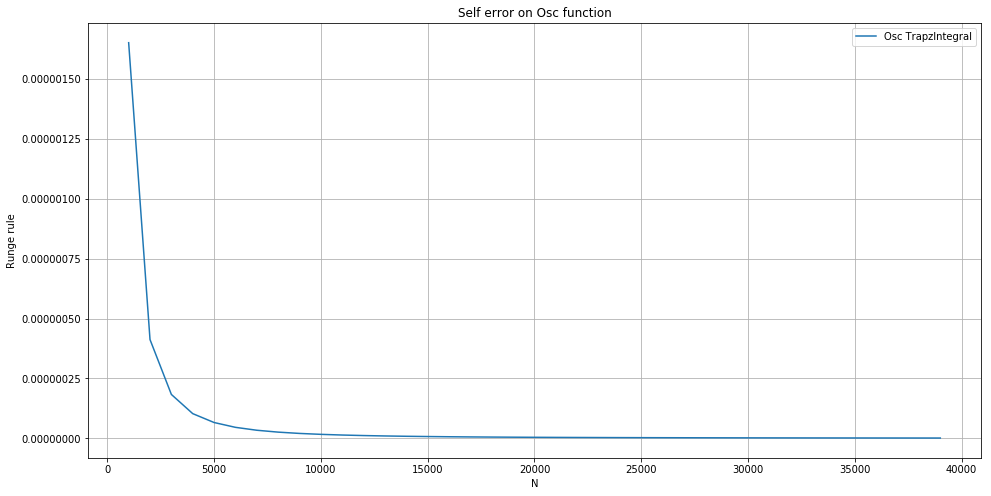

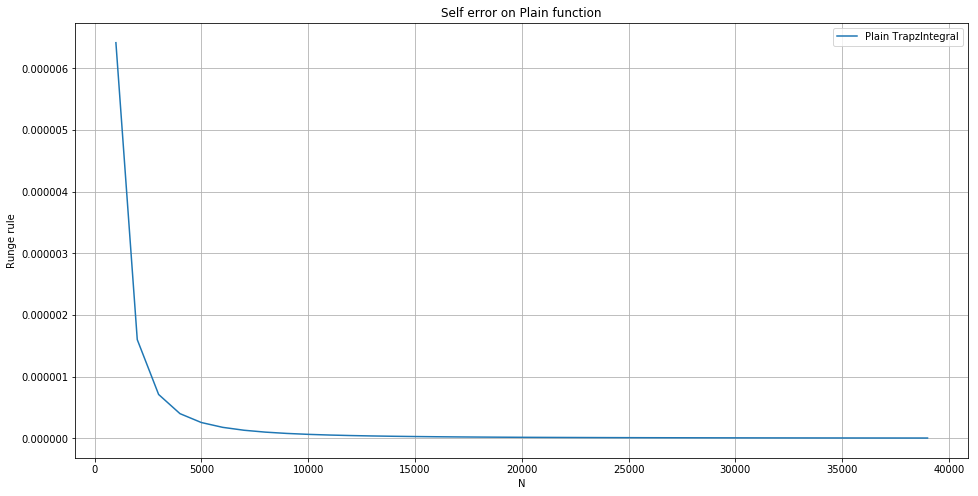

In [17]:
from functools import partial

def self_error(nodes_num, method, func=None):
    return method.error(func, beg, end, nodes_num)

def error_compare(nodes_num, method, func=None):
    etalon, err = integrate.quad(func, beg, end)
    integr = method(func, nodes_num=nodes_num)
    my_val = integr(begin=beg, end=end)

    return abs(my_val - etalon)

for func, name in [(gap_func, 'Gap'), (osc_func, 'Osc'), (plain_func, 'Plain')]:
    plt.figure(figsize=(16, 8))
    rng = np.arange(1000, 40000, 1000)
    for method in [TrapzIntegral]:
        plt.title(f'Self error on {name} function')
        mk_plot(
            partial(self_error, func=func, method=method),
            rng,
            name + ' ' + method.__name__,
            same=True
        )

        plt.xlabel('N')
        plt.ylabel('Runge rule')
        plt.show()

Видно, что для разрывной функции ошибка сильно скачет.

Построим график относительной ошибки в лог-scale для осцелирующей функции.

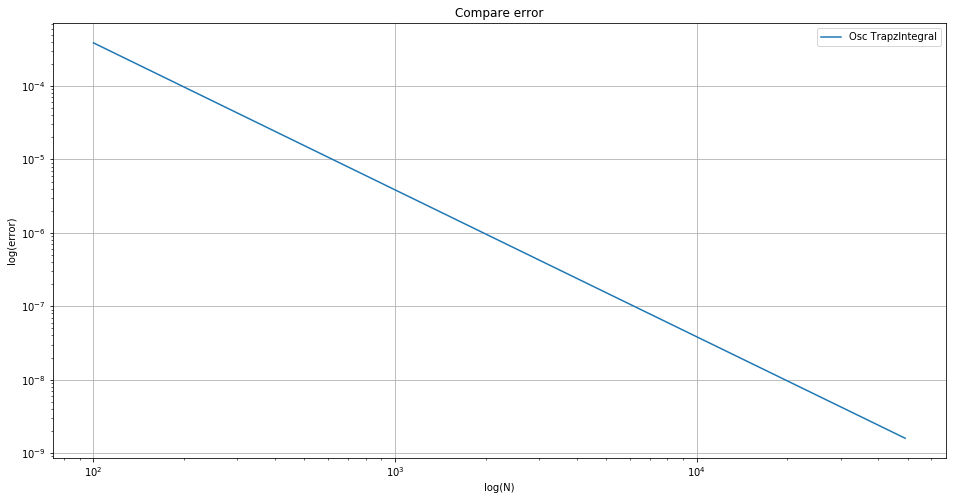

In [21]:
for func, name in [(osc_func, 'Osc')]:
    rng = np.arange(100, 50000, 1000)
    plt.figure(figsize=(16, 8))
    for method in [TrapzIntegral]:
        mk_plot(
            partial(error_compare, func=func, method=method),
            rng,
            name + ' ' + method.__name__,
            same=True
        )

plt.title('Compare error')
plt.xlabel('log(N)')
plt.ylabel('log(error)')
plt.yscale('log')
plt.xscale('log')
plt.show()

Видно, что коэфициент наклона $\approx -2$, а смещение можно оценить на глазок как $0.5$. Тогда можно оценить $c$ как 
$e^{\sqrt{10}}$, а порядок точности – 3-кой, что подтверждает аналитическую оценку.

Выводы: работает вполне точно для неразрывных функций.